# 👖 Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from utils import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [71]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 1. Prepare the data <a name="prepare"></a>

In [72]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [73]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

print("x_train size is ", x_train.shape)
print("x_test size is  ", x_test.shape)

x_train size is  (60000, 32, 32, 1)
x_test size is   (10000, 32, 32, 1)


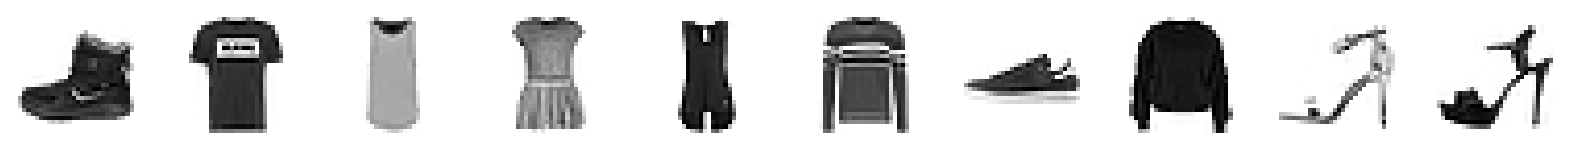

In [74]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

In [75]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
print("encoder_input shape is ",encoder_input.shape)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!
print("The shape before flattening is ", shape_before_flattening)

x = layers.Flatten()(x)
print("x shape is ",x.shape)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)
print("encoder_output shape is ", encoder_output.shape)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

encoder_input shape is  (None, 32, 32, 1)
The shape before flattening is  (4, 4, 128)
x shape is  (None, 2048)
encoder_output shape is  (None, 2)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)       

In [76]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_10 (Conv2  (None, 16, 16, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_11 (Conv2  (None, 32, 32, 32)        184

In [77]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_10 (Functional)       (None, 32, 32, 1)         246

## 3. Train the autoencoder <a name="train"></a>

In [78]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [79]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [80]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2943INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 30s 50ms/step - loss: 0.2943 - val_loss: 0.2605
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2567INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 30s 50ms/step - loss: 0.2567 - val_loss: 0.2570
Epoch 3/3
599/600 [============================>.] - ETA: 0s - loss: 0.2533INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


600/600 [==============================] - 29s 48ms/step - loss: 0.2533 - val_loss: 0.2542


In [81]:
# Save the final models
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/autoencoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [82]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 2s 9ms/step
Example real clothing items


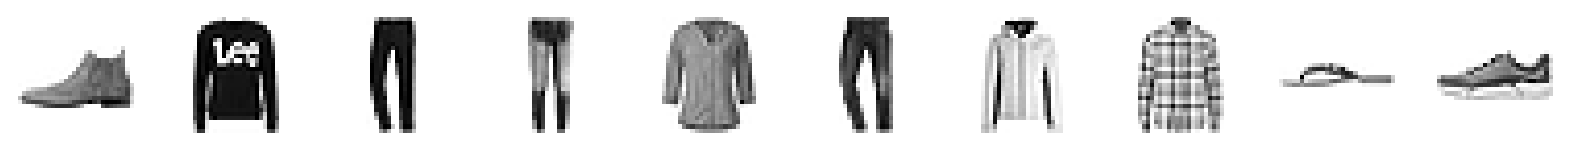

Reconstructions


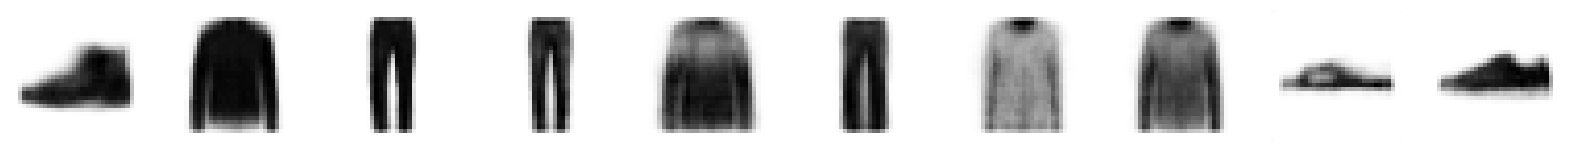

In [83]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

In [84]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [85]:
# Some examples of the embeddings
print(embeddings[:10])

[[-0.8955091  -3.5430083 ]
 [-8.780906    1.7877687 ]
 [-0.3668038   8.586745  ]
 [ 0.2251094   5.4816175 ]
 [-4.6567163   0.32993764]
 [-1.211632    6.3551536 ]
 [-2.0291607   0.70995003]
 [-3.7602842   0.914454  ]
 [ 1.2043358  -1.1330216 ]
 [ 1.0829868  -2.7098463 ]]


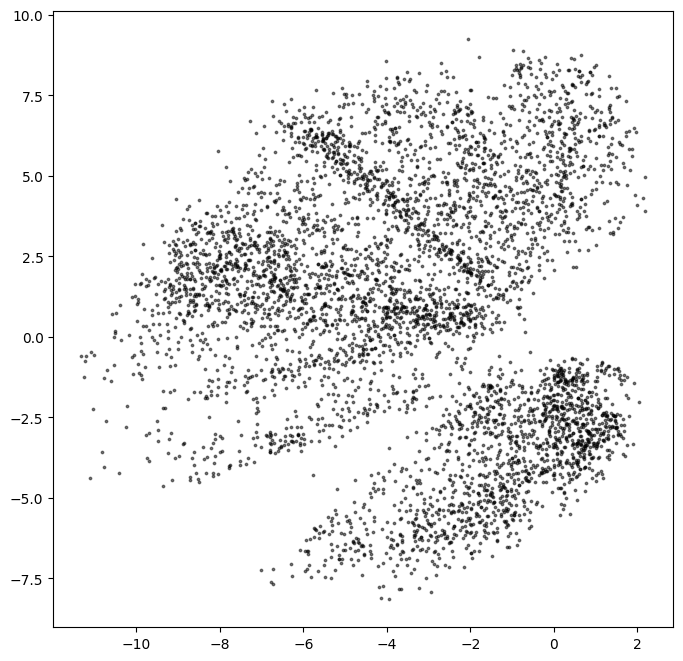

In [86]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

example labels size is  (5000,)


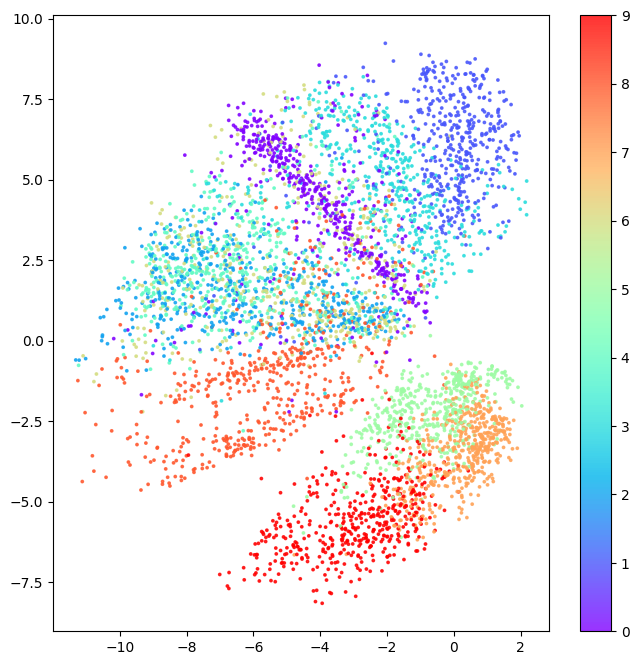

In [87]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]
print("example labels size is ", example_labels.shape)

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder <a name="decode"></a>

In [88]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

print("mins shape is ", mins.shape)
print("maxs shape is ", maxs.shape)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)

print("size will be computed as %d by %d" % (grid_height * grid_width, EMBEDDING_DIM))


sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

mins shape is  (2,)
maxs shape is  (2,)
size will be computed as 18 by 2


In [92]:
# Decode the sampled points
print("sample has shape ",sample.shape)
reconstructions = decoder.predict(sample)

sample has shape  (18, 2)
1/1 [==============================] - 0s 16ms/step


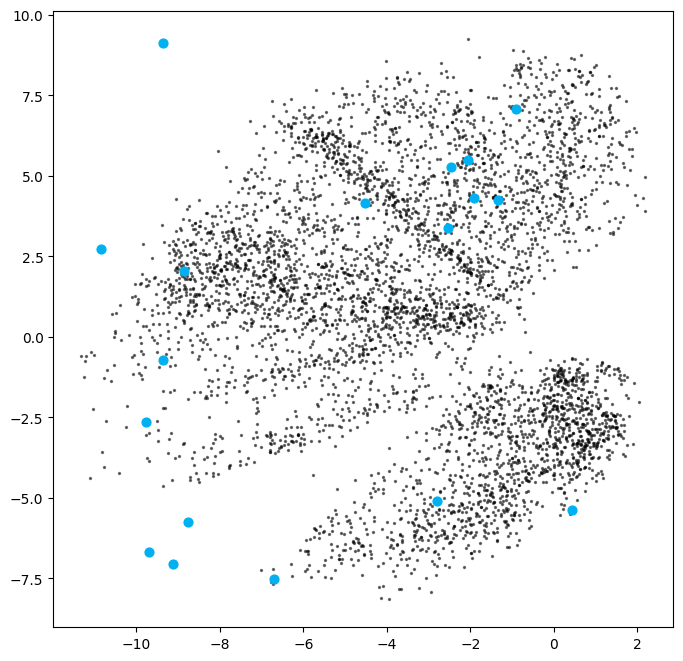

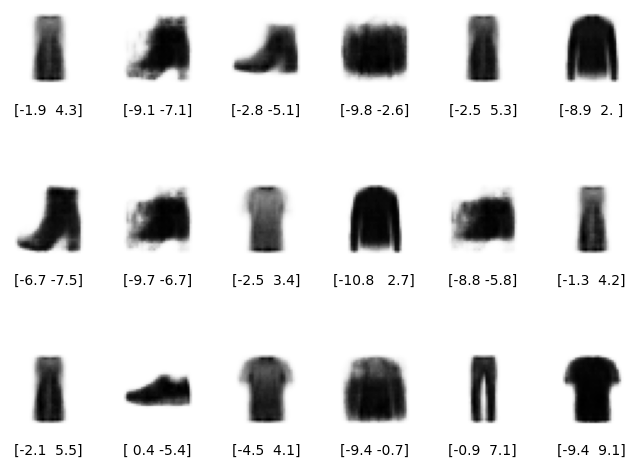

In [90]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 [==============================] - 0s 7ms/step


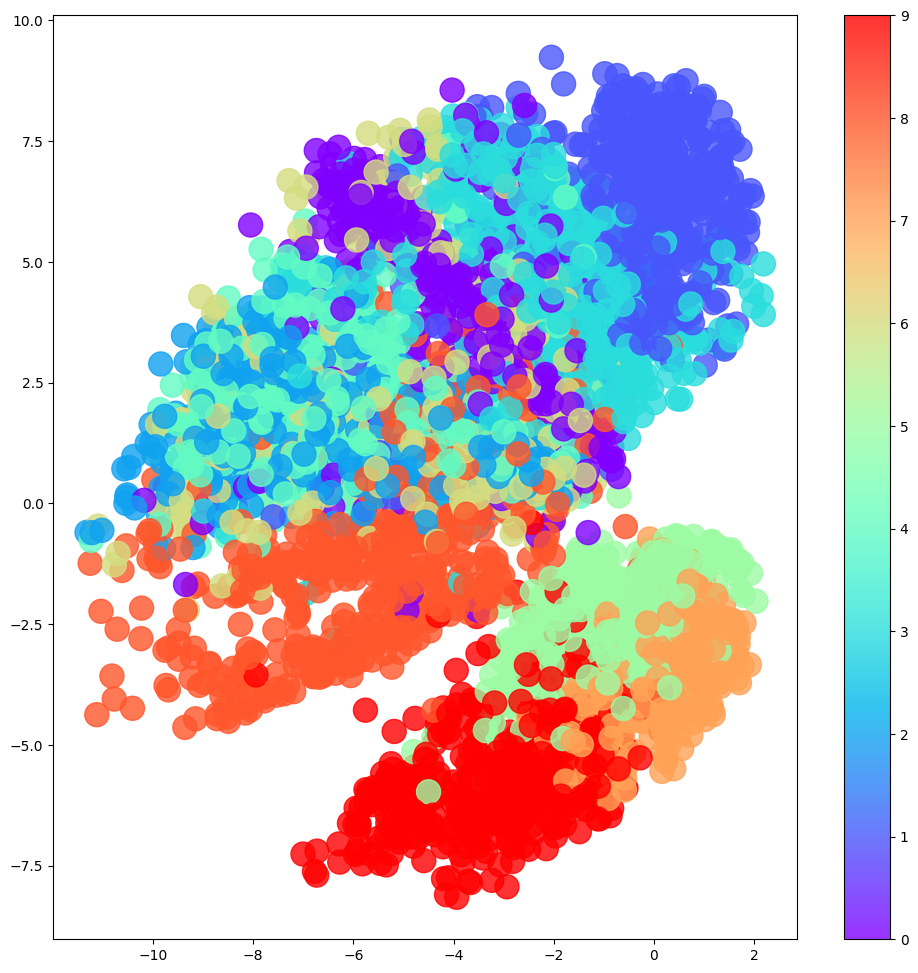

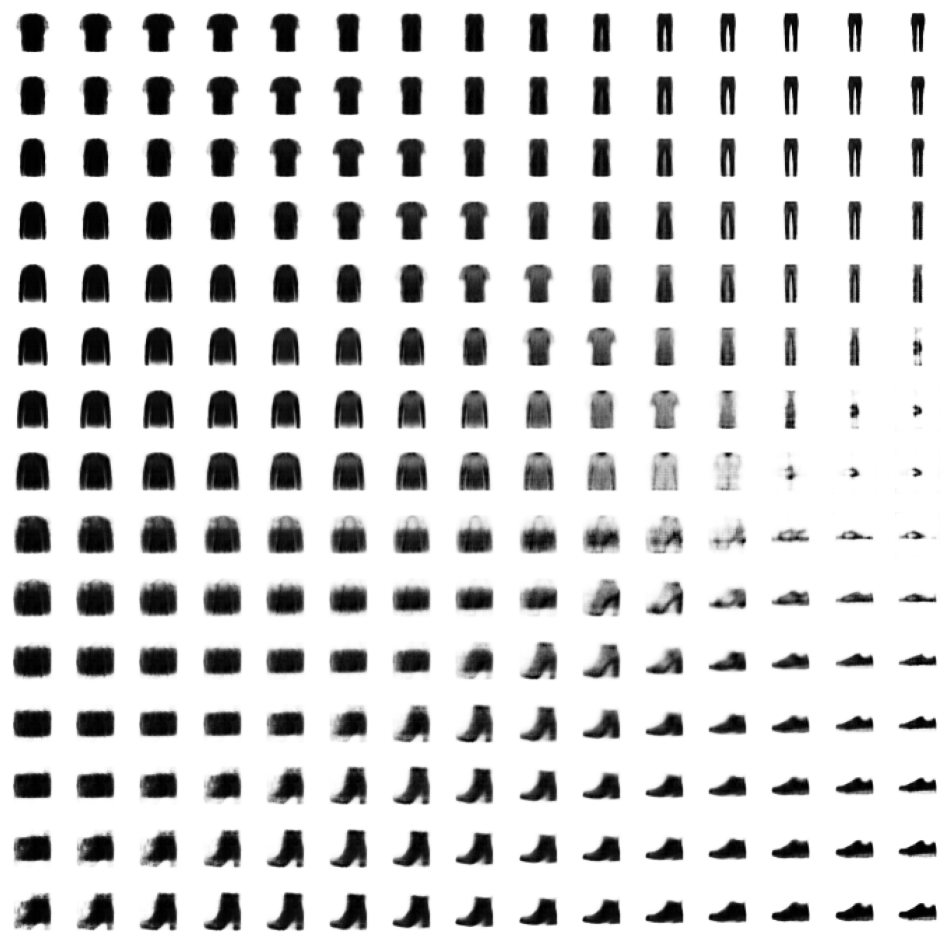

In [91]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")